# VRP with EA

## 1. Creating Customers function

In [92]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time


CUSTOMERS = []
VEHICLES = 0


def create_map(SIZE):
  if(SIZE=="SMALL"):
    CUSTOMER_COUNT = np.random.randint(10, 20)
    VEHICLES = np.random.randint(2, 10)
  elif(SIZE=="MEDIUM"):
    CUSTOMER_COUNT = np.random.randint(15, 30)
    VEHICLES = np.random.randint(11, 25)
  elif(SIZE=="LARGE"):
    CUSTOMER_COUNT = np.random.randint(20, 50)
    VEHICLES = np.random.randint(26, 50)

  customers = set()

  # Generating a set of unique customers
  while len(customers) < CUSTOMER_COUNT:
      point = tuple(int(x) for x in np.random.randint(-20, 20, size=2))  # (x, y) within [0, 20)
      customers.add(point)
  customers = list(customers)
  customers.insert(0,(0,0))
  return customers, VEHICLES


ModuleNotFoundError: No module named 'numpy'

## 2. Create Individual function

In [ ]:
def create_individual(vehicles):
    customers = list(range(1, len(CUSTOMERS)))  # exclude depot (index 0)
    random.shuffle(customers)

    individual = [[] for _ in range(vehicles)]

    for cust in customers:
        chosen_vehicle = random.randint(0, vehicles - 1)  # assign randomly
        individual[chosen_vehicle].append(cust)

    return individual

## 3. Fitness function

In [ ]:
def fitness(individual):
    individual = decode_individual(individual) #adding depot for start and end
    total_distance = 0

    for route in individual:  # go through each vehicle's route
        if len(route) > 1:  # if vehicle visits more than one customer
            for i in range(1, len(route)):
                x1, y1 = CUSTOMERS[route[i-1]]
                x2, y2 = CUSTOMERS[route[i]]
                total_distance += ((x2 - x1)**2 + (y2 - y1)**2)**0.5

    return 1 / total_distance if total_distance > 0 else 0


def decode_individual(individual):
    return [[0] + route + [0] for route in individual]

## 4. Selection Function

In [ ]:
def tournament_selection(population, k=3):
    tournament = random.sample(population, k)
    return max(tournament, key=fitness)

## 5. Mutation functions

In [ ]:
def swap_mutation(individual):
    vehicle = random.choice([v for v in individual if len(v) > 1])
    i, j = random.sample(range(len(vehicle)), 2)
    vehicle[i], vehicle[j] = vehicle[j], vehicle[i]
    return individual


def relocation_mutation(individual):
    # pick a non-empty vehicle as source
    from_vehicle = random.choice([v for v in individual if v])
    customer = from_vehicle.pop(random.randrange(len(from_vehicle)))

    # pick a different vehicle as target
    candidates = [v for v in individual if v is not from_vehicle]
    to_vehicle = random.choice(candidates)

    # insert at random position
    insert_pos = random.randint(0, len(to_vehicle))
    to_vehicle.insert(insert_pos, customer)

    return individual


def mutate(individual):
    chance = random.random()
    if chance <= 0.1:  # 10% mutation rate for demonstration
      if chance < 0.05: # 50% of each mutation type
        relocation_mutation(individual)
      else: swap_mutation(individual)
    return individual

## 6. Crossover function

In [ ]:
def order_crossover(parent1, parent2):
    number_of_customers = sum(len(r) for r in parent1)

    # 1. Create lists without vehicle format from parents
    parent1_to_list = [c for route in parent1 for c in route]
    parent2_to_list = [c for route in parent2 for c in route]

    # 2. Pick random crossover points and add to child
    start, end = sorted(random.sample(range(len(parent1_to_list)), 2))
    child_list = [None]*number_of_customers
    child_list[start:end+1] = parent1_to_list[start:end+1]

    # 3. Fill remaining customers from parent2 in order
    pointer = (end + 1) % len(child_list)
    for c in parent2_to_list:
        if c not in child_list:
            child_list[pointer] = c
            pointer = (pointer + 1) % len(child_list)

    # 4. Split child list into vehicle routes based on parent1 format
    child = []
    idx = 0
    for vehicle in parent1:
        route_length = len(vehicle)
        child.append(child_list[idx:idx+route_length])
        idx += route_length

    return child

## 7. Visulazation of individual

In [ ]:
def visualize_individual (individual,fitness):
  individual= decode_individual(individual)
  output="Individual:\n"

  vehicles_used = 0

  for i in range(len(individual)):
    if (len(individual[i])>2):
      vehicles_used+=1;
    route = " -> ".join(map(str, individual[i]))

    output+=f"- Vehicle {i+1}: "+route+"\n"
  output+=f"Vehicles used: {vehicles_used}/{VEHICLES}\n"
  output+=f"Fitness score: {fitness}\n"

  return output

In [ ]:
def graph_map(individual):
  individual = decode_individual(individual)

  plt.figure(figsize=(10, 10))
  x, y = zip(*CUSTOMERS)

  plt.grid()
  plt.scatter(x, y)

  for vehicle in individual:
    color = np.random.rand(3,)
    for i in range(len(vehicle)-1):
      plt.annotate("",xy=(x[vehicle[i+1]], y[vehicle[i+1]]),xytext=(x[vehicle[i]], y[vehicle[i]]),
                    arrowprops=dict(arrowstyle="->", color=color, lw=2))
  plt.show()

## 8. Genetic Algorithm

In [ ]:
def genetic_algorithm(CROSSOVER_RATE,GENERATIONS,POPULATION_SIZE):
    # Timer for runtime
    start_time = time.time()

    # Initilization of individuals
    INDIVIDUALS = []
    best_fitness = 0
    best_generation = 0

    for i in range(POPULATION_SIZE):
      INDIVIDUALS.append(create_individual(VEHICLES))

    for generation in range(GENERATIONS):
        # Evaluation
        INDIVIDUALS = sorted(INDIVIDUALS, key=fitness, reverse=True)
        # if generation % 10 == 0:
        #     best = INDIVIDUALS[0]
        #     print(f"Generation {generation}: {visualize_individual(best, fitness(best))} \n\n")

        # Selection
        new_population = []

        # Elitism
        new_population.extend([INDIVIDUALS[0], INDIVIDUALS[1]])

        # Find when best fitness was discovered
        if best_fitness < fitness(INDIVIDUALS[0]):
          best_fitness = fitness(INDIVIDUALS[0])
          best_generation = generation

        while len(new_population) < POPULATION_SIZE:
            parent1 = tournament_selection(INDIVIDUALS)
            parent2 = tournament_selection(INDIVIDUALS)

            #Crossover
            if random.random() < CROSSOVER_RATE:
              offspring1 = order_crossover(parent1, parent2)
              offspring2 = order_crossover(parent2, parent1)

            else:
                offspring1, offspring2 = parent1, parent2

            # Mutation
            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)


            new_population.extend([offspring1, offspring2])

        INDIVIDUALS = new_population[:POPULATION_SIZE]

    #Calculating time for the algorithm
    #print("--- %s seconds ---" % (time.time() - start_time))
    total_time = time.time() - start_time
    print("The best fitness, " + str(best_fitness) + ", was found in generation " + str(best_generation) + "\n")
    return max(INDIVIDUALS, key=fitness), total_time


## 9. Runtime

### Generate map based on size

In [ ]:
# RUN TO CHOOSE SMALL RANDOM MAP
# CUSTOMERS,VEHICLES = create_map("SMALL")

# TEST MAP 1
CUSTOMERS = [(0, 0), (-15, 4), (15, -11), (3, 8), (8, 17), (9, 3), (11, -13), (8, -8), (8, -16), (-13, 10), (11, -14), (16, 5), (19, -17), (1, -16), (16, 14), (2, 5), (-10, -8), (-7, 15)]
VEHICLES = 5

# TEST MAP 2
# CUSTOMERS = [(0, 0), (-20, -1), (13, 4), (3, -11), (10, 8), (5, 8), (-4, -9), (-7, -1), (15, 13), (-20, 9), (-18, -10), (7, 2), (15, 9), (-2, -4), (-12, -12), (0, 17)]
# VEHICLES = 2


In [ ]:
# RUN TO CHOOSE MEDIUM RANDOM MAP
# CUSTOMERS,VEHICLES = create_map("MEDIUM")

# TEST MAP 3
# CUSTOMERS = [(0, 0), (-19, -8), (-5, -3), (6, -19), (-3, 15), (7, -11), (15, -4), (-16, 5), (-7, 17), (-14, -19), (-13, 13), (-14, -7), (-19, 6), (9, 7), (-20, -5), (9, 13), (14, -13), (3, -13), (-14, -2), (-7, -12), (15, -3), (-1, -7), (16, 17)]
# VEHICLES = 17

# TEST MAP 4
# CUSTOMERS = [(0, 0), (-4, 17), (17, -9), (-2, 8), (8, -18), (-10, 10), (-8, -17), (19, 3), (-16, -10), (-20, 5), (18, 7), (3, 0), (-18, -20), (2, -1), (-18, 4), (-17, -3), (17, -17), (12, -4), (-14, -1), (-9, -18), (19, 4), (-5, 7), (-5, 16), (15, -18), (-17, -13), (6, -9), (6, 6)]
# VEHICLES = 24

In [ ]:
# RUN TO CHOOSE LARGE RANDOM MAP
# CUSTOMERS,VEHICLES = create_map("LARGE")

# TEST MAP 5
# CUSTOMERS = [(0, 0), (-5, -9), (12, 16), (13, -19), (-10, 13), (10, -9), (-9, -13), (-16, -13), (-8, 1), (-15, -8), (10, 15), (-1, -5), (6, 2), (2, 14), (-7, 8), (16, 16), (1, 12), (-13, 16), (-10, 12), (4, 8), (-5, 5), (3, 12), (19, 2), (-11, 19), (5, 3), (17, 14), (8, 11), (-18, -8), (18, -18), (-1, -18), (12, -16), (-2, -3), (-17, 12), (-16, 7), (15, 16), (-10, 2), (-11, 6), (-4, 15), (9, -12), (-11, 3), (17, 4), (-14, -2), (0, -6), (13, 3), (6, 3)]
# VEHICLES = 44

# TEST MAP 6
# CUSTOMERS = [(0, 0), (-19, -2), (-1, 14), (-14, -12), (-11, 11), (-12, 13), (0, 2), (17, 12), (10, 6), (18, -5), (12, -18), (7, -1), (-18, 8), (-4, 1), (6, 5), (15, 17), (19, -10), (11, -14), (10, -10), (2, -20), (14, 12), (-8, -15), (4, 17), (9, 7), (18, -15), (6, -17), (-9, -1), (-20, 4), (-15, -9), (-2, -18), (-16, -5), (-1, -12), (-14, 17), (-7, 16), (17, -20), (-3, -17), (-2, 12), (-13, 12), (14, 5), (5, 2), (4, 10), (-6, 8), (-12, -14), (-9, 6), (-13, -4), (3, -8), (-13, 5)]
# VEHICLES = 32

### Runtime for map

GA values Crossover rate: 0.9 Generations: 10 Population Size: 10
FINAL RESULT: Individual:
- Vehicle 1: 0 -> 4 -> 14 -> 15 -> 7 -> 0
- Vehicle 2: 0 -> 8 -> 1 -> 16 -> 5 -> 11 -> 0
- Vehicle 3: 0 -> 13 -> 3 -> 9 -> 0
- Vehicle 4: 0 -> 2 -> 12 -> 6 -> 10 -> 0
Vehicles used: 4/4
Fitness score: 0.0034017666231422774 




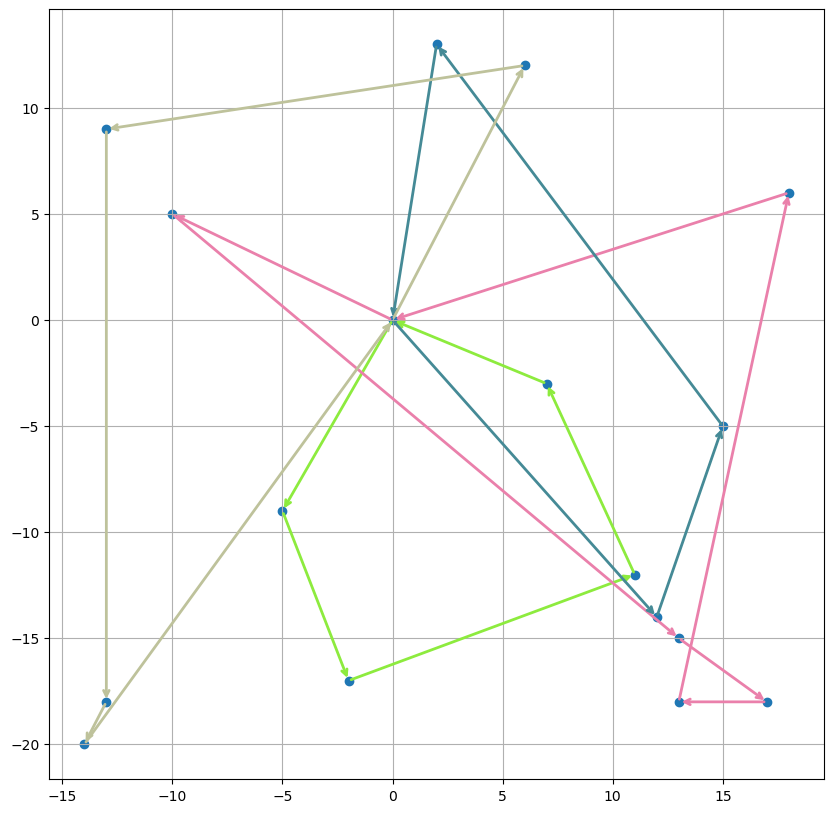

GA values Crossover rate: 0.8 Generations: 100 Population Size: 20
FINAL RESULT: Individual:
- Vehicle 1: 0 -> 9 -> 2 -> 11 -> 0
- Vehicle 2: 0 -> 3 -> 1 -> 16 -> 5 -> 13 -> 15 -> 7 -> 0
- Vehicle 3: 0 -> 12 -> 8 -> 6 -> 10 -> 14 -> 0
- Vehicle 4: 0 -> 4 -> 0
Vehicles used: 4/4
Fitness score: 0.004882348559031664 




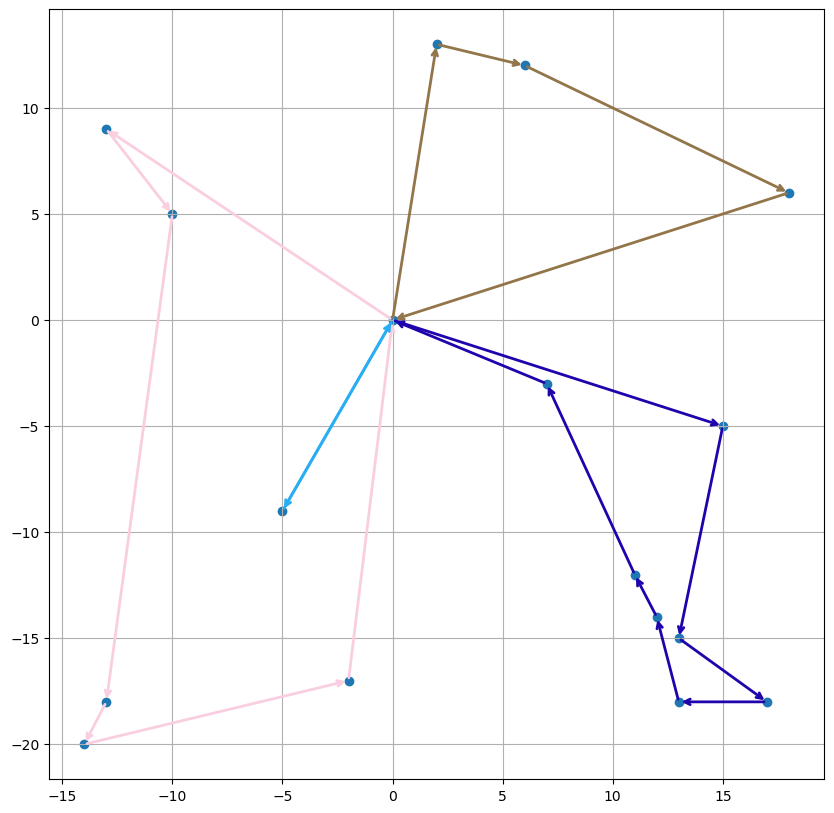

GA values Crossover rate: 0.95 Generations: 300 Population Size: 100
FINAL RESULT: Individual:
- Vehicle 1: 0 -> 0
- Vehicle 2: 0 -> 7 -> 13 -> 5 -> 16 -> 1 -> 15 -> 3 -> 11 -> 0
- Vehicle 3: 0 -> 14 -> 10 -> 6 -> 4 -> 0
- Vehicle 4: 0 -> 2 -> 9 -> 12 -> 8 -> 0
Vehicles used: 3/4
Fitness score: 0.0056126475826929175 




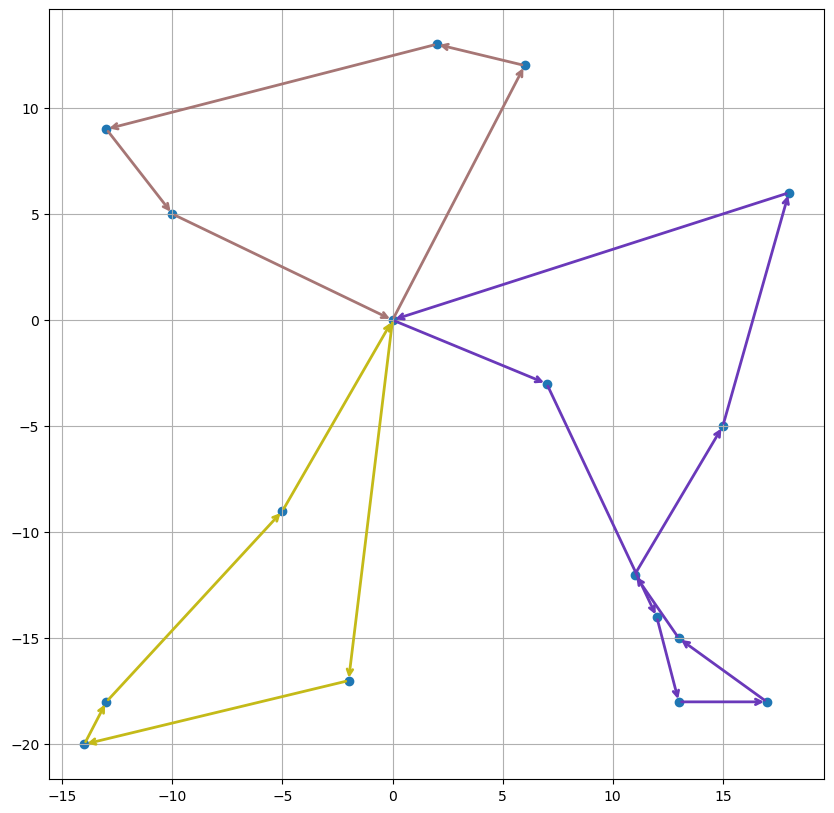

In [ ]:
GA_values = [(0.9,10,50),(0.8,100,20),(0.95,300,100)]

x,y,z = GA_values[2]

print(f"GA values Crossover rate:",x,"Generations:",y,"Population Size:",z, "\n")
result, total_time = genetic_algorithm(CROSSOVER_RATE=x,GENERATIONS=y,POPULATION_SIZE=z)

print(f"FINAL RESULT: {visualize_individual(result, fitness(result))}")
print("Function took " + str(round(total_time, 3)) + " seconds")

graph_map(result)